In [55]:
from src.data import HARDataSet
from src.models import KAN, MLP
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [56]:
X_train_file = "dataset/HAR/train/X_train.txt"
y_train_file = "dataset/HAR/train/y_train.txt"
X_test_file = "dataset/HAR/test/X_test.txt"
y_test_file = "dataset/HAR/test/y_test.txt"

train_dataset = HARDataSet(X_train_file, y_train_file)
test_dataset = HARDataSet(X_test_file, y_test_file)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

epochs = 100

In [57]:
def train(model, train_loader, test_loader, epochs, total_test_samples):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    train_losses, test_losses, accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred_test = model(X_batch)
                loss = criterion(y_pred_test, y_batch)
                test_loss += loss.item()

                pred = y_pred_test.argmax(dim=1, keepdim=True).squeeze()
                correct += pred.eq(y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        accuracies.append(correct / total_test_samples)

    return train_losses, test_losses, accuracies

In [58]:
def print_results(train_losses, test_losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label="Accuracy", color="r")
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

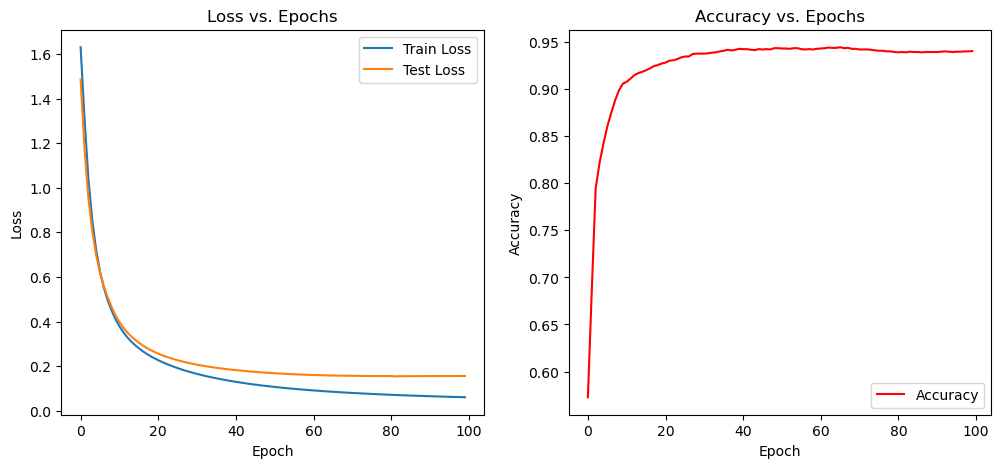

In [59]:
MLP = MLP()
train_losses, test_losses, accuracies = train(
    MLP, train_loader, test_loader, epochs, total_test_samples=len(test_dataset)
)

print_results(train_losses, test_losses, accuracies)

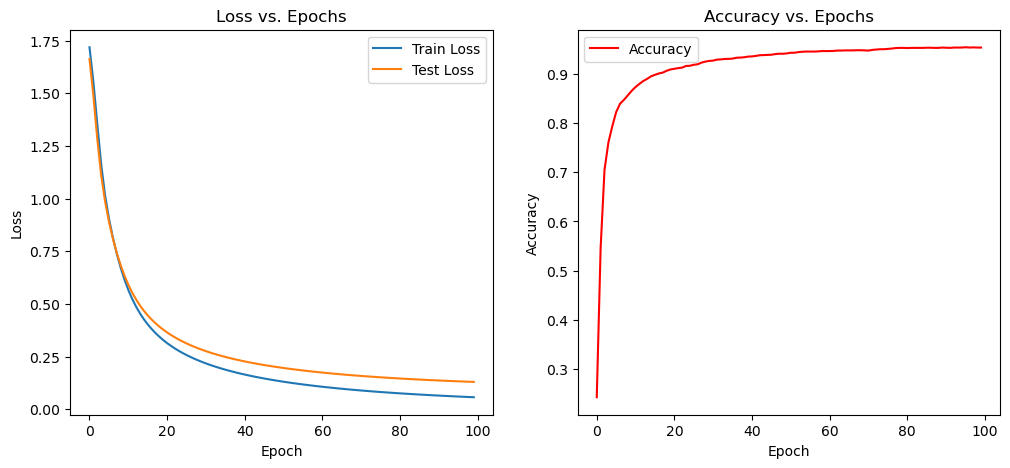

In [60]:
KAN = KAN([561, 64, 6])
train_losses, test_losses, accuracies = train(
    KAN, train_loader, test_loader, epochs, total_test_samples=len(test_dataset)
)

print_results(train_losses, test_losses, accuracies)

In [61]:
def add_label_noise(y_train: torch.Tensor, noise_level):
    num_swap_labels = int(
        np.round(len(y_train) * noise_level)
    )  # calculate the number of labels to swap
    np.random.seed(42)
    swap_indices = np.random.choice(
        len(y_train), num_swap_labels * 2, replace=False
    )  # randomly select indices to swap

    for i in range(0, len(swap_indices), 2):
        y_train[swap_indices[i]], y_train[swap_indices[i + 1]] = (
            y_train[swap_indices[i + 1]],
            y_train[swap_indices[i]],
        )

    return y_train

In [62]:
train_dataset.y = add_label_noise(train_dataset.y, 0.05)

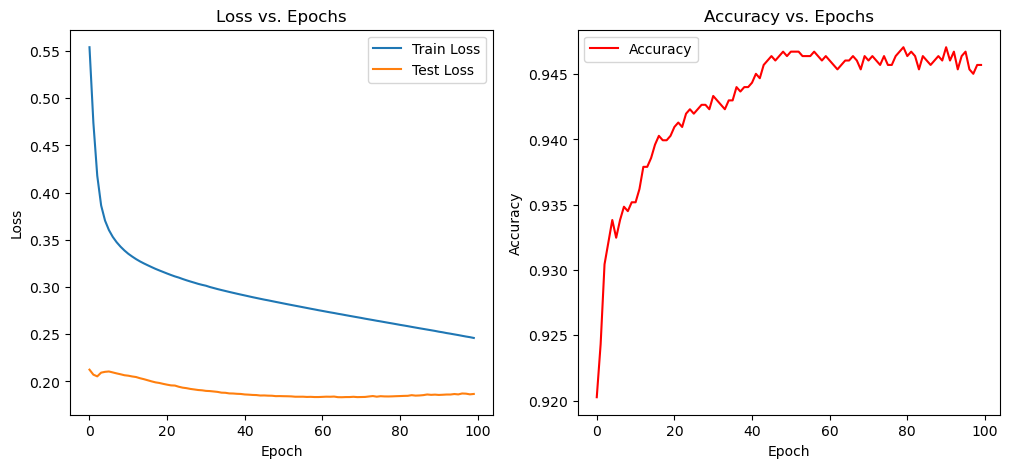

In [63]:
train_losses, test_losses, accuracies = train(
    MLP, train_loader, test_loader, epochs, total_test_samples=len(test_dataset)
)

print_results(train_losses, test_losses, accuracies)

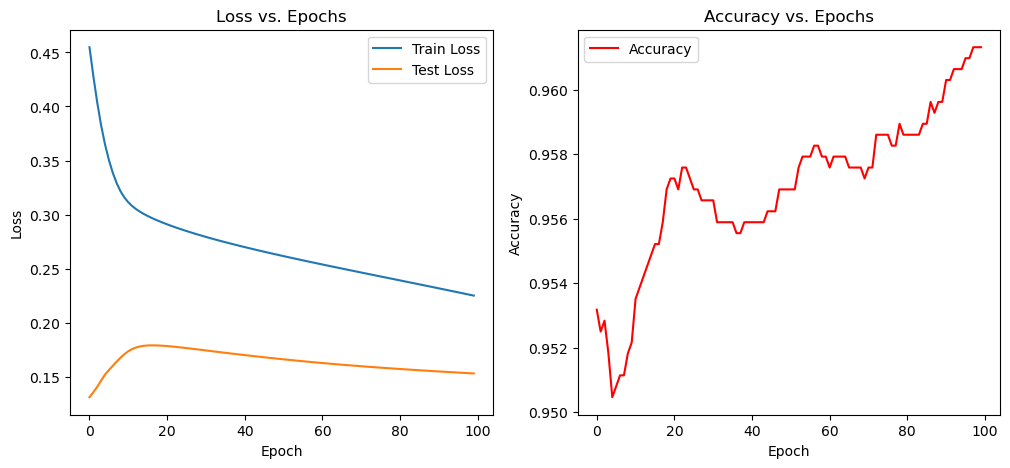

In [64]:
train_losses, test_losses, accuracies = train(
    KAN, train_loader, test_loader, epochs, total_test_samples=len(test_dataset)
)

print_results(train_losses, test_losses, accuracies)

In [65]:
train_dataset.y = add_label_noise(train_dataset.y, 0.1)

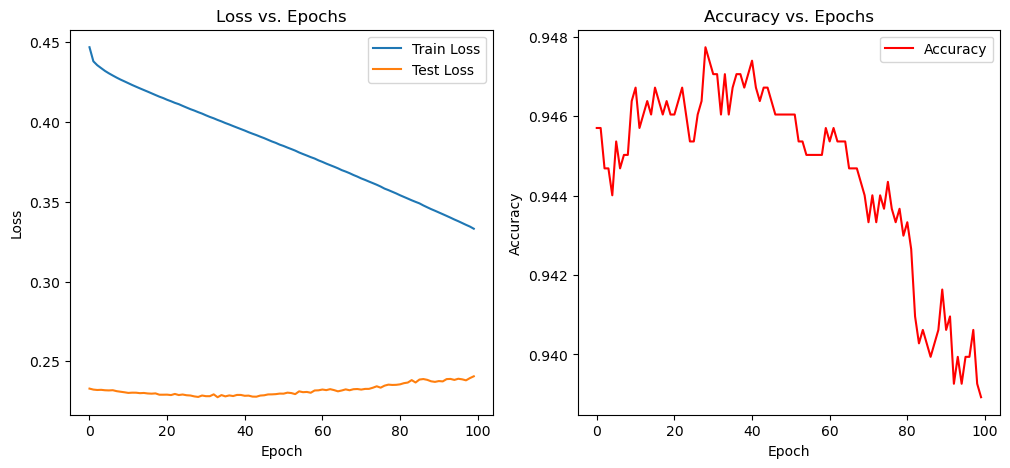

In [66]:
train_losses, test_losses, accuracies = train(
    MLP, train_loader, test_loader, epochs, total_test_samples=len(test_dataset)
)

print_results(train_losses, test_losses, accuracies)

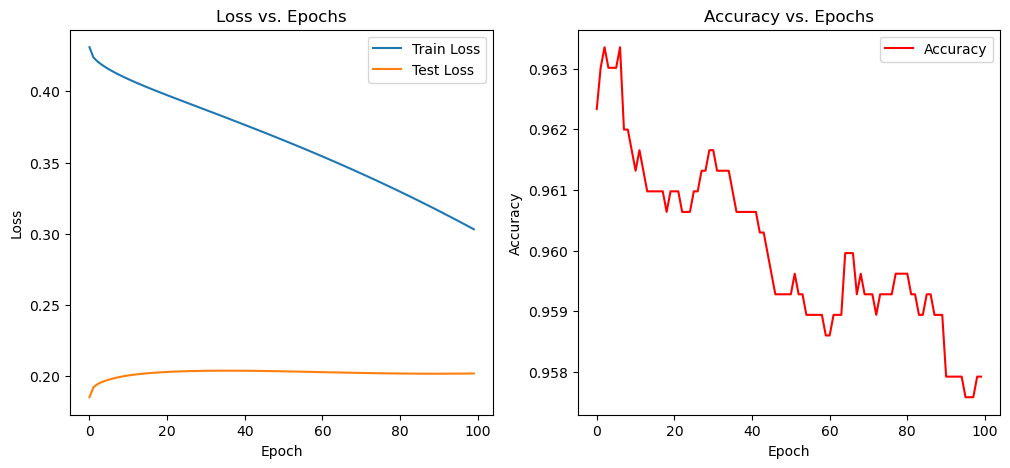

In [67]:
train_losses, test_losses, accuracies = train(
    KAN, train_loader, test_loader, epochs, total_test_samples=len(test_dataset)
)

print_results(train_losses, test_losses, accuracies)